In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import interval
import tensorflow as tf
from interval import Interval
import tensorflow.keras as keras
import nn_reachability_tf as nn_reachability
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
def F_car(state_interval,action_interval):

    power = 0.0015

    min_action, max_action = -1., 1.
    min_position, max_position = -1.2, 0.6
    max_speed = 0.07

    position = state_interval.extract(axis=0)
    velocity = state_interval.extract(axis=1)

    #Careful, p index
    # action_interval = action_interval.clip(min_action, max_action, axis=0)
    velocity = velocity + action_interval.alpha(power) - position.alpha(3).cos(axis=0).alpha(0.0025)
    
    velocity = velocity.clip(-max_speed, max_speed)

    position = position + velocity
    position = position.clip(min_position, max_position)
    
    

    #How to add that?? is it important for intervals??
    # if position == min_position and velocity < 0:
    #     velocity = 0

    return position.combine(velocity)

In [3]:
def F_car_point(x,action):
    
    power = 0.0015

    min_action, max_action = -1., 1.
    min_position, max_position = -1.2, 0.6
    max_speed = 0.07

    position = x[0]
    velocity = x[1]
    
    #Careful, p index
    # action_interval = action_interval.clip(min_action, max_action, axis=0)
    velocity = velocity + power*action - 0.0025*np.cos(3*position)
    
    velocity = np.clip(velocity, -max_speed, max_speed)

    position = position + velocity
    position = np.clip(position, min_position, max_position)
   
    #How to add that?? is it important for intervals??
    # if position == min_position and velocity < 0:
    #     velocity = 0

    return np.array([position, velocity])

In [4]:
def reach_car(state_interval, action_interval, epsilon, N, input_x=0, input_y=1, output_x=0, output_y=1):
    eta = state_interval
    low, high = state_interval.high_low()
    H_state = np.concatenate([np.linspace(low[i], high[i], N).reshape(N, 1) for i in range(state_interval.intervals.shape[0])], axis=1)

    low, high = action_interval.high_low()
    H_action = np.concatenate([np.linspace(low[i], high[i], N).reshape(N, 1) for i in range(action_interval.intervals.shape[0])], axis=1)

    usim_set = np.array([F_car_point(H_state[i], H_action[j]) for i in range(H_state.shape[0]) for j in range(H_action.shape[0])]).reshape(N**2, state_interval.intervals.shape[0])
    usim = nn_reachability.create_interval(usim_set)

    u = F_car(state_interval, action_interval)

    ax_input = nn_reachability.plot_interval(eta, input_x, input_y)
    ax_output = nn_reachability.plot_interval(usim, output_x, output_y, 'r')
    ax_output = nn_reachability.add_to_plot(ax_output, u, output_x, output_y, 'r')
    print(usim_set.shape)
    ax_output.scatter(usim_set[:,0], usim_set[:,1])
    #decoupage sur action_interval aussi ou pas??

    ue = []
    etae = []
    M = [(state_interval, u)]

    while len(M) > 0:
        (eta, u) = M.pop(0)
        if u.is_included(usim):
            ue.append(u)
            etae.append(eta)
            color = np.random.rand(3,)
            ax_output = nn_reachability.add_to_plot(ax_output, u, output_x, output_y, color)
            ax_input = nn_reachability.add_to_plot(ax_input, eta, input_x, input_y, color)
            continue
        else:
            if eta.length() > epsilon:
                eta1, eta2 = eta.bissection()
                ax_input = nn_reachability.add_to_plot(ax_input, eta1, input_x, input_y, "b")
                ax_input = nn_reachability.add_to_plot(ax_input, eta2, input_x, input_y, "b")
                
                u1 = F_car(eta1, action_interval)
                u2 = F_car(eta2, action_interval)

                M.append((eta1, u1))
                M.append((eta2, u2))
            else:
                ue.append(u)
                etae.append(eta)

    
    ue = ue + [u for (eta, u) in M]
    etae = etae + [eta for (eta, u) in M]

    # for interv, inp_interv in zip(ue, etae):
    #     color = np.random.rand(3,)
    #     ax_output = add_to_plot(ax_output, interv, output_x, output_y, color)
    #     ax_input = add_to_plot(ax_input, inp_interv, input_x, input_y, color)

    ue = nn_reachability.over_appr_union(ue)
    ax_output = nn_reachability.add_to_plot(ax_output, ue, output_x, output_y)

    plt.show()

    return ue


In [5]:
def cut_state_interval(state_interval, epsilon):
    intervals = []
    M = [state_interval]

    while len(M)>0:
        interval = M.pop(0)

        if interval.length() > epsilon:
            interval1, interval2 = interval.bissection()
            M.append(interval1)
            M.append(interval2)
            
        else:
            intervals.append(interval)
    
    return intervals

[[0.9999947 1.       ]] [[1. 1.]]


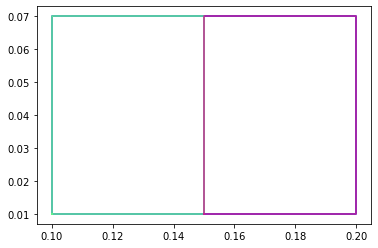

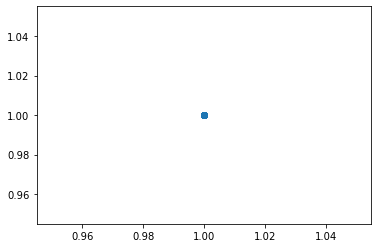

(10000, 2)


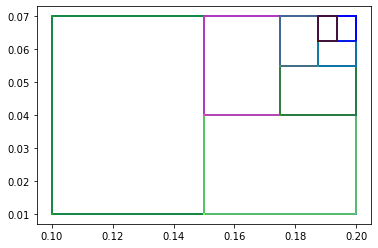

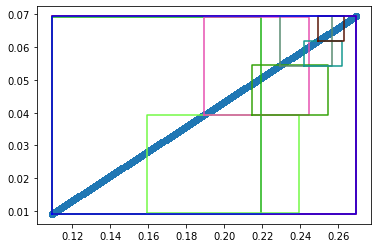

In [58]:
model = keras.models.load_model("../ddpg/models/car_actor.tf")
state_interval = Interval(interval = [(0.10, 0.2), (0.01, 0.07)])
low, high = state_interval.high_low()
H = np.concatenate([np.linspace(low[0], high[0], 5000).reshape(5000,1), np.linspace(low[1], high[1], 5000).reshape(5000,1)], axis=1)
action_interval = nn_reachability.reachMLP(model, H, 0.01, 5000, input_y=1, output_y=0)
reach_car(state_interval, action_interval, 0.01, 100)

In [6]:
def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

def angle_normalize_interval(theta):
    theta_underline = theta.intervals[0][0]
    theta_overline = theta.intervals[0][1]
    return Interval(interval=[[min(angle_normalize(theta_underline), angle_normalize(theta_overline)), max(angle_normalize(theta_underline), angle_normalize(theta_overline))]])

def F_pendulum(state_interval,action_interval):

    max_speed = 8
    max_torque = 2.0
    dt = 0.05
    g = 10.0
    m = 1.0
    l = 1.0

    th = state_interval.extract(axis=0)
    thdot = state_interval.extract(axis=1)

    action_interval.clip(-max_torque, max_torque)
    
    # costs = (th.apply_incr(angle_normalize))**2 + (thdot**2).alpha(0.1) + (action_interval ** 2).alpha(0.001)
    
    newthdot = thdot + (th.sin()).alpha(3 *dt* g / (2 * l)) + action_interval.alpha((3.0 / (m * l ** 2)) * dt)
    newthdot = newthdot.clip(-max_speed, max_speed)
    
    newth = angle_normalize_interval(th + newthdot.alpha(dt))
    # print(th.intervals, action_interval.intervals)
    # print(thdot.intervals, newthdot.intervals)
    return newth.combine(newthdot)


In [7]:
def F_double_integrator(state_interval, action_interval):

    min_action, max_action = -1, 1

    x0 = state_interval.extract(axis=0)
    x1 = state_interval.extract(axis=1)

    # action_interval = action_interval.clip(min_action, max_action)

    newx0 = x0 + x1
    newx1 = x1 + action_interval

    return newx0.combine(newx1)

In [8]:
def f_double_integrator(x, u):
  
    A = np.array([[1, 1], [0, 1]])
    B = np.expand_dims(np.array([0, 1]), axis=0).T
    

    return (A.dot(x.T) + B.dot(u)).T

In [10]:
def play_double_integrator(controller, input_interval = None, n_iterations=200):
    if input_interval is None:
        x0 = np.random.rand(1,2)
        print(x0)
    
    states = [x0[0]]
    actions = []

    for i in range(n_iterations):
        action = controller(x0)
        x0 = f_double_integrator(x0, action)

        states.append(x0[0])
        actions.append(action)
    
    return states, actions

In [11]:
model = keras.models.load_model("./models/mpc.tf")
states, actions = play_double_integrator(model)
states, actions = np.array(states), np.array(actions)

[[0.70550793 0.13005078]]


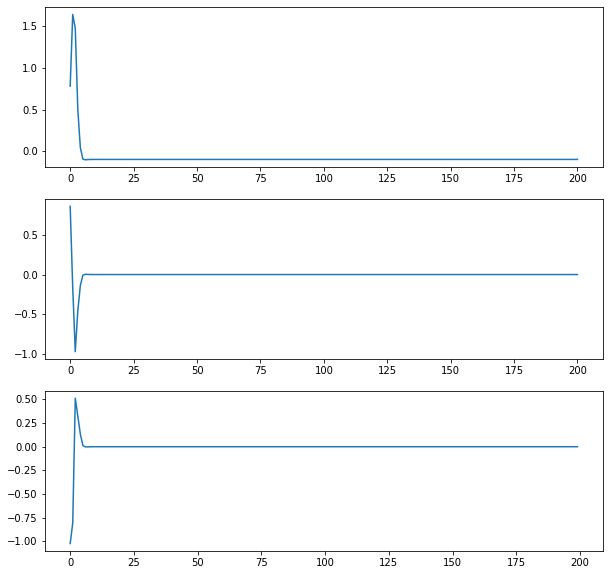

In [126]:
fig, axs = plt.subplots(3, figsize=(10, 10))
axs[0].plot(states[:, 0])
axs[1].plot(states[:, 1])
axs[2].plot(actions[:, 0])

No specification interval


100%|██████████| 5/5 [00:00<00:00, 108.08it/s]


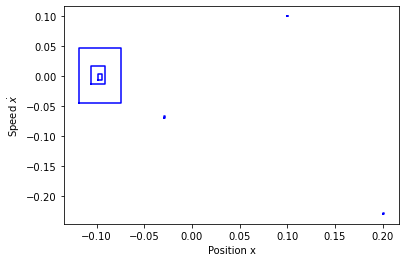

In [22]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/mpc.tf")
    state_interval = Interval(interval = [(0.1, 0.101), (0.1, 0.1)])
    epsilon = 1
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-0.0001, 0.0001]])
    state_interval = interval_approximation(5, model, F_double_integrator, state_interval, None, epsilon, epsilon_states=None, plot_jumps=1)

In [ ]:
model = keras.models.load_model("../ddpg/models/car_actor.tf")
state_interval = Interval(interval = [(0.10, 0.2), (0.01, 0.07)])
low, high = state_interval.high_low()
H = np.concatenate([np.linspace(low[0], high[0], 5000).reshape(5000,1), np.linspace(low[1], high[1], 5000).reshape(5000,1)], axis=1)
action_interval = nn_reachability.reachMLP(model, H, 0.01, 5000, input_y=1, output_y=0)

In [176]:
model = keras.models.load_model("../ddpg/models/car_actor.tf")
state_interval = Interval(interval = [(0.10, 0.2), (0.01, 0.07)])
low, high = state_interval.high_low()
H = np.concatenate([np.linspace(low[0], high[0], 5000).reshape(5000,1), np.linspace(low[1], high[1], 5000).reshape(5000,1)], axis=1)
action_interval = nn_reachability.reachMLP(model, H, 0.01, 5000, input_y=1, output_y=0)

In [ ]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/pendulum_actor_64.tf")
    state_interval = Interval(interval = [(0, 0.00), (0,0)])
    for i in range(100):
        low, high = state_interval.high_low()
        theta = np.linspace(low[0], high[0], 5000).reshape(5000,1)
        H = np.concatenate([np.random.uniform(low[0], high[0], 5000).reshape(5000,1), np.random.uniform(low[1], high[1], 5000).reshape(5000,1)], axis=1)
        action_interval = nn_reachability.reachMLP_pendulum(model, H, 0.001, 5000, input_y=1, output_y=0)
        state_interval = F_pendulum(state_interval, action_interval)
state_interval.intervals

In [49]:
new_state_interval = F_car(state_interval, action_interval)

[[0.01 0.07]]
[[0.00911166 0.06943666]]


In [50]:
new_state_interval.intervals

array([[0.10911166, 0.26943666],
       [0.00911166, 0.06943666]])

In [13]:
def interval_approximation_simple(T, model, F, state_interval, epsilon, specification_interval, f=nn_reachability.reachMLP, plot_jumps = 1, plot=True):
    plot_temp = False
    
    specification = True
    if specification_interval == None:
        print("No specification interval")
        specification=False

    low, high = state_interval.high_low()
    H = np.concatenate([np.random.uniform(low[0], high[0], 5000).reshape(5000,1), np.random.uniform(low[1], high[1], 5000).reshape(5000,1)], axis=1)
    action_interval = f(model, H, epsilon, 5000, input_y=1, output_y=0)

    if plot:
        ax_state = nn_reachability.plot_interval(state_interval, 0, 1)
        ax_state.set_xlabel(r"Position x")
        ax_state.set_ylabel(r"Speed $\dot{x}$")

    for i in tqdm(range(T), disable=not(plot)):
        if False:
            print(i)
        if (i%plot_jumps==0) and plot:
            plot_temp=True
        state_interval = F(state_interval, action_interval)

        if plot:
            ax_state = nn_reachability.add_to_plot(ax_state, state_interval, 0, 1)

        if specification:
            if state_interval.is_included(specification_interval):
                if plot:
                    ax_state = nn_reachability.add_to_plot(ax_state, state_interval, 0, 1, 'r')
                break


        low, high = state_interval.high_low()
        if False:
            print("finished system reachability")
        #Modify the way we compute H
        H = np.concatenate([np.linspace(low[0], high[0], 5000).reshape(5000,1), np.linspace(low[1], high[1], 5000).reshape(5000,1)], axis=1)
    
        action_interval = f(model, H, epsilon, 1000, input_y=1, output_y=0, plot=plot_jumps-1)
        if plot_jumps - 1==1:
            state_plot = nn_reachability.plot_interval(state_interval, 0, 1)
            plt.show()
            # action_plot = nn_reachability.plot_interval(action_interval, 0, 0)
            # plt.show()
        plot_temp = False

    plt.show()

    return state_interval

In [14]:
def interval_approximation_pendulum(T, model, F, state_interval, epsilon, specification_interval, f=nn_reachability.reachMLP, plot_jumps = 1, plot=True):

    plot_temp = False
    
    low, high = state_interval.high_low()
    H = np.concatenate([np.random.uniform(low[0], high[0], 5000).reshape(5000,1), np.linspace(low[1], high[1], 5000).reshape(5000,1)], axis=1)
    action_interval = f(model, H, epsilon, 5000, input_y=1, output_y=0)

    if plot:
        ax_state = nn_reachability.plot_interval(state_interval, 0, 1)
        ax_state.set_xlabel(r"Position $\theta$")
        ax_state.set_ylabel(r"Speed $\dot{\theta}$")
        
    for i in tqdm(range(T), disable=not(plot)):
        if False:
            print(i)
        if (i%plot_jumps==0) and plot:
            plot_temp=True
        state_interval = F(state_interval, action_interval)

        low,high = state_interval.high_low()

        if plot:
            ax_state = nn_reachability.add_to_plot(ax_state, state_interval, 0, 1)
            
            # print(state_interval.intervals)
            # ax_state = nn_reachability.plot_interval( state_interval, 0, 1)
            # plt.show()

            

        if state_interval.is_included(specification_interval):
            if plot:
                ax_state = nn_reachability.add_to_plot(ax_state, state_interval, 0, 1, 'r')
            break


        if False:
            print("finished system reachability")
        H = np.concatenate([np.linspace(low[0], high[0], 5000).reshape(5000,1), np.linspace(low[1], high[1], 5000).reshape(5000,1)], axis=1)
        action_interval = f(model, H, epsilon, 1000, input_y=1, output_y=0, plot=plot_jumps-1)
        if plot_jumps - 1==1:
            state_plot = nn_reachability.plot_interval(state_interval, 0, 1)
            plt.show()
            # action_plot = nn_reachability.plot_interval(action_interval, 0, 0)
            # plt.show()
        plot_temp = False

    plt.show()

    return state_interval


In [15]:
def interval_approximation(T, model, F, state_interval, specification_interval, epsilon_nn, epsilon_states=None, f= nn_reachability.reachMLP, plot_jumps=1, plot=True):

    if F != F_pendulum:
        approx = interval_approximation_simple
    else:
        approx = interval_approximation_pendulum

    if epsilon_states == None:
        #Need more general expression for H
        if F != F_pendulum:
            low, high = state_interval.high_low()
            H = np.concatenate([np.random.uniform(low[0], high[0], 5000).reshape(5000,1), np.random.uniform(low[1], high[1], 5000).reshape(5000,1)], axis=1)
        if F == F_pendulum:
            low,high = state_interval.high_low()
            H = np.concatenate([np.random.uniform(low[0], high[0], 5000).reshape(5000,1), np.random.uniform(low[1], high[1], 5000).reshape(5000,1)], axis=1)
        action_interval = f(model, H, epsilon, 5000, input_y=1, output_y=0)

        return approx(T, model, F, state_interval, epsilon_nn, specification_interval, f=f, plot_jumps=plot_jumps, plot=plot)
    
    state_intervals = cut_state_interval(state_interval, epsilon_states)
    
    outputs = []

    for i in tqdm(range(len(state_intervals))):
        #print("here")
        state_interval = state_intervals[i]

        outputs.append(approx(T, model, F, state_intervals[i], epsilon, specification_interval, f=f, plot_jumps=plot_jumps, plot=False))
    
    output_interval =  nn_reachability.over_appr_union(outputs)

    if plot:
        ax_output = nn_reachability.plot_interval(outputs[0], x_axis=0, y_axis=1)
        for interval in outputs[1:]:
            ax_output = nn_reachability.add_to_plot(ax_output, interval, x_axis=0, y_axis=1)
        plt.show()
    
    return outputs

100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


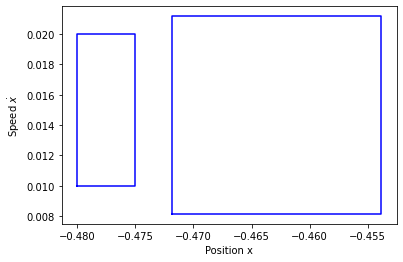

In [26]:
# model = keras.models.load_model("../ddpg/models/car_actor.tf")
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/car_actor_speed_interval.tf")
    state_interval = Interval(interval = [(-0.48, -0.475), (0.01,0.02)])
    specification_interval = Interval(interval=[[0.6, np.infty], [-0.07, 0.07]])
    epsilon = 0.01
    interval_approximation_simple(1, model, F_car, state_interval, epsilon, specification_interval,plot_jumps=10)

  0%|          | 0/10 [00:00<?, ?it/s]

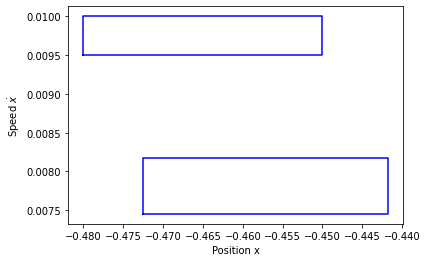

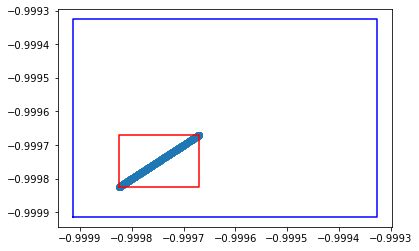

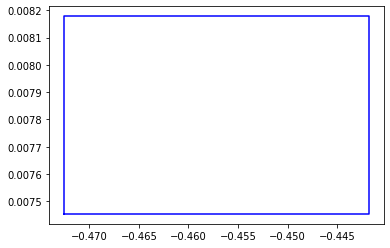

 10%|█         | 1/10 [00:00<00:02,  3.17it/s]

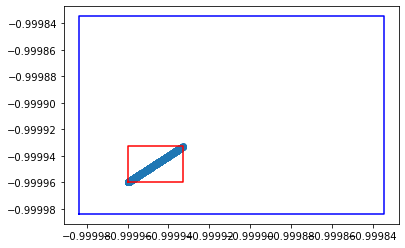

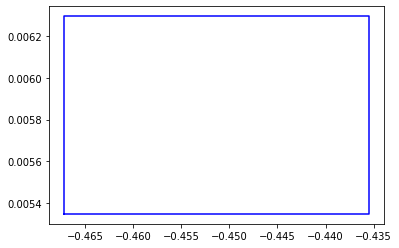

 20%|██        | 2/10 [00:00<00:01,  4.07it/s]

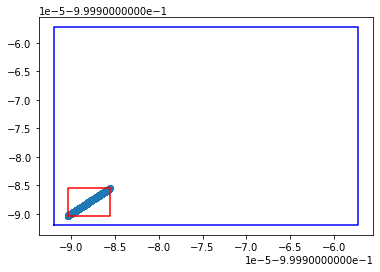

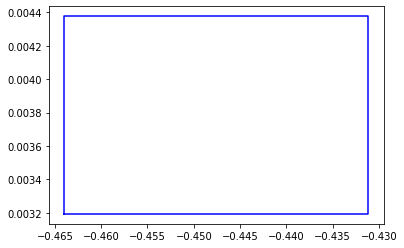

 30%|███       | 3/10 [00:00<00:01,  4.28it/s]

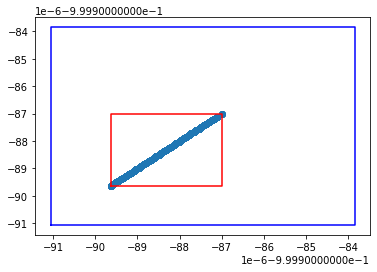

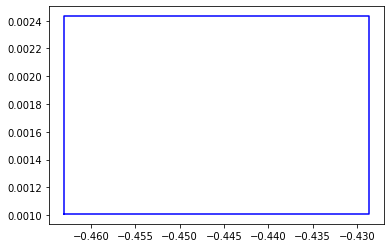

 40%|████      | 4/10 [00:01<00:01,  4.01it/s]

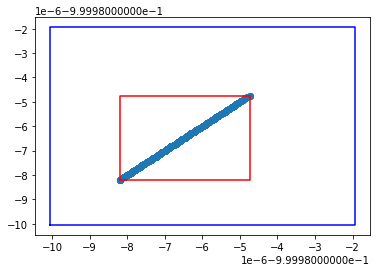

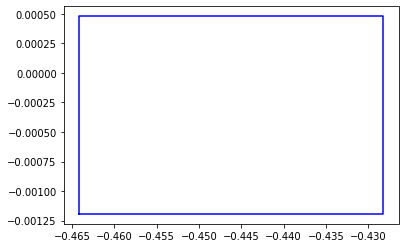

 50%|█████     | 5/10 [00:01<00:01,  4.29it/s]

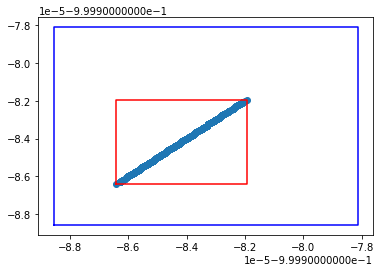

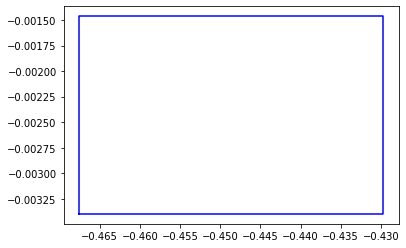

 60%|██████    | 6/10 [00:01<00:00,  4.52it/s]

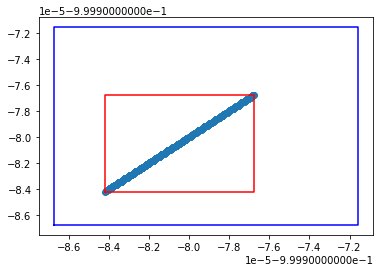

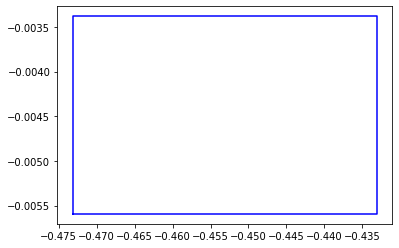

 70%|███████   | 7/10 [00:01<00:00,  4.69it/s]

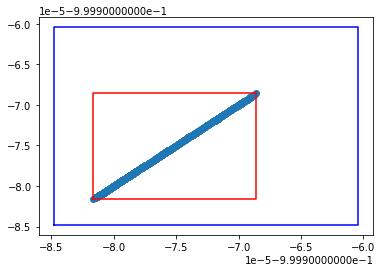

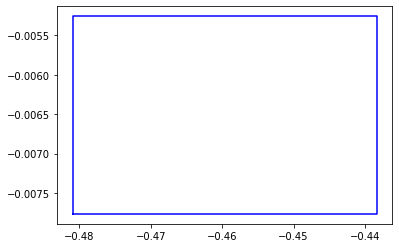

 80%|████████  | 8/10 [00:01<00:00,  4.90it/s]

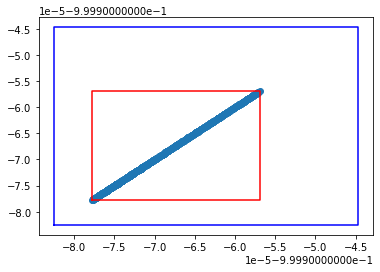

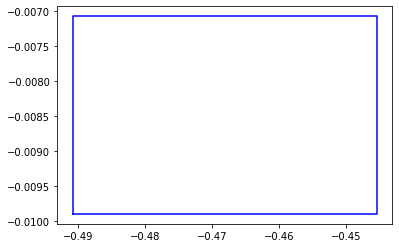

 90%|█████████ | 9/10 [00:01<00:00,  4.97it/s]

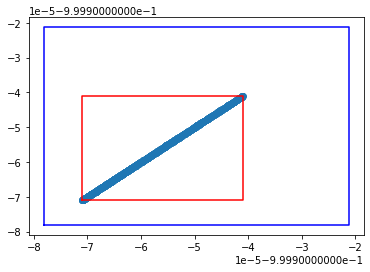

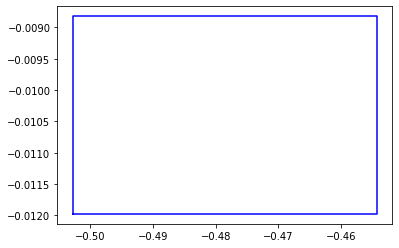

100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


In [187]:
# model = keras.models.load_model("../ddpg/models/car_actor.tf")
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/car_actor_speed_interval.tf")
    state_interval = Interval(interval = [(-0.48, -0.45), (0.0095,0.01)])
    specification_interval = Interval(interval=[[0.6, np.infty], [-0.07, 0.07]])
    epsilon = 0.01
    interval_approximation(10, model, F_car, state_interval, specification_interval, epsilon, epsilon_states=None, plot_jumps=2)

In [ ]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/pendulum_smooth_actor3.tf")
    state_interval = Interval(interval = [(np.pi, np.pi), (1, 1)])
    epsilon=1
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
    state_interval  = interval_approximation_pendulum(100, model, F_pendulum, state_interval,epsilon, specification_interval, plot_jumps=2, f=nn_reachability.reachMLP_pendulum)
state_interval.intervals

100%|██████████| 30/30 [00:00<00:00, 133.54it/s]


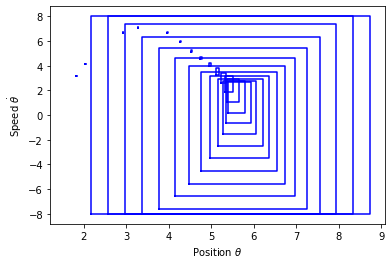

array([[ 2.16865298,  8.73092401],
       [-8.        ,  8.        ]])

In [21]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("./models/pendulum_actor_16_small_interval.tf")
    state_interval = Interval(interval = [(np.pi/2+0.001, np.pi/2+0.005), (1.05, 1.05)])
    epsilon=1
    specification_interval = Interval(interval=[[-0.0001, 0.0001], [-8, 8]])
    state_interval  = interval_approximation_pendulum(30, model, F_pendulum, state_interval,epsilon, specification_interval, f=nn_reachability.reachMLP_pendulum)
state_interval.intervals

In [438]:
with tf.device('/cpu:0'):
    model = keras.models.load_model("../ddpg/models/pendulum_actor.tf")
    state_interval = Interval(interval = [(0.5, 0.501), (0, 0)])
    epsilon=0.1
    specification_interval = Interval(interval=[[-0.01, 0.01], [-8, 8]])
    action_interval = nn_reachability.reachMLP_pendulum(model, H, state_interval, epsilon, 5000, input_y=1, output_y=0)
    interval_approximation(20, model, F_pendulum, state_interval, specification_interval, epsilon, epsilon_states=0.001, f=nn_reachability.reachMLP_pendulum)

TypeError: only integer scalar arrays can be converted to a scalar index